In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Note:

Put %load _filename_ at the top of a cell and then run the cell to load the contents of a file to that cell.

Put %%file _filename_ at the top of a cell and then run to write the contents of that cell to the specified file.

# Funnynet - Preprocessing

Special thanks to taivop for providing the [dataset](https://github.com/taivop/joke-dataset).

This notebook is heavily inspired by [fastai NLP work](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb).

This contains our initial exploration into the data set as well as the final preprocessing done on the data set for all other experiments.

In [1]:
%%file preprocessing.py 

import json
from pathlib import Path
import math, random
import pickle


def files_to_indexed_list(data_size = -1):
    BOS = 'xbos'  # beginning-of-sentence tag
    FLD = 'xfld'  # data field tag
    EOJ = 'xeoj'  # end of joke tag

    #get jokes:
    PATH=Path('data')

    files = list(PATH.iterdir())

    for fname in files:
        if "eddit" in str(fname):
            reddit_dataset = str(fname)
        if "upid" in str(fname):
            stupid_dataset = str(fname)
    reddit_jokes = json.load(open(reddit_dataset))
    stupid_jokes = json.load(open(stupid_dataset))

    #discard reddit jokes with 0 score:
    rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

    #regularize to match stupid_jokes:
    title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]

    all_jokes = []
    for i in range(len(reddit_jokes)):
        r_joke = reddit_jokes[i]
        #|print(r_joke)
        r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
        if r_joke['rating']>5:
            r_joke['rating']=5
        del r_joke['score'] 
        r_joke['body'] = r_joke['title']+" "+r_joke['body']
        del r_joke['title']
    for s_joke in stupid_jokes:
        del s_joke['category']

    #combine joke sets:
    combined_jokes = reddit_jokes + stupid_jokes

    title_body = [joke['body']+' ' for joke in combined_jokes]

    
    #make into a very long string:
    text = ''
    if data_size == -1: #either combine them all
        text = " " + EOJ + " "
        text = text.join(title_body)
    else: #or just consider the first many characters
        for joke in title_body:
            text = text + ' ' + joke + ' ' + EOJ + ' '
            if len(text) > data_size: 
                break

    #get a set of all characters in the text:
    chars = sorted(list(set(text)))
    vocab_size = len(chars)+1

    chars.insert(0, "\0")

    #index characters in text:
    char_indices = {c: i for i, c in enumerate(chars)}
    indices_char = {i: c for i, c in enumerate(chars)}

    idx = [char_indices[c] for c in text]

    return (idx, char_indices, indices_char)

def format():
    PATH='data/'

    TRN_PATH = 'trn/'
    VAL_PATH = 'val/'
    TRN = f'{PATH}{TRN_PATH}'
    VAL = f'{PATH}{VAL_PATH}'

    idx = files_to_indexed_list()

    trn = open(TRN+"trn.txt","w")
    trn.write("test")
    trn.write(str(idx[0:int(len(idx)*2/3)]))
    trn.close()
    val = open(VAL+"val.txt","w")
    val.write("test")
    val.write(str(idx[int(len(idx)*2/3):len(idx)-1]))
    val.close()
    
def save_data_to_pickle(pickle_name, data_size = -1):
    data = files_to_indexed_list(data_size)
    pickle_file = open(pickle_name,'wb')
    pickle.dump(data, pickle_file)
    pickle_file.close()
    return data
    
def load_data(pickle_name):
    pickle_file = open(pickle_name,'rb')
    idx, char_indices, indices_char = pickle.load(pickle_file)
    pickle_file.close()
    return (idx, char_indices, indices_char)


Overwriting preprocessing.py


## Initial exploration of corpus:

In [2]:
import pdb
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math, random

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
EOJ = 'xeoj'  # end of joke tag

PATH=Path('data')

In [4]:
files = list(PATH.iterdir())
print(files)

[PosixPath('data/val'), PosixPath('data/trngit'), PosixPath('data/trn'), PosixPath('data/stupidstuff.json'), PosixPath('data/models'), PosixPath('data/reddit_jokes.json')]


In [5]:
for fname in files:
    if "eddit" in str(fname):
        reddit_dataset = str(fname)
    if "upid" in str(fname):
        stupid_dataset = str(fname)
reddit_jokes = json.load(open(reddit_dataset))
stupid_jokes = json.load(open(stupid_dataset))

In [6]:
len(reddit_jokes)

194553

In [7]:
reddit_jokes[0]

{'body': 'Now I have to say "Leroy can you please paint the fence?"',
 'id': '5tz52q',
 'score': 1,
 'title': 'I hate how you cant even say black paint anymore'}

Let's discard all the jokes that have 0 score, as they aren't that helpful for training

In [8]:
rated_jokes = [joke for joke in reddit_jokes if joke['score'] > 0]

In [9]:
len(rated_jokes)

132992

In [10]:
scores = [joke['score'] for joke in rated_jokes]
np.mean(scores),np.max(scores)

(172.94791416025024, 48526)

Let's see how many jokes have really high scores:

In [11]:
len([score for score in scores if score>5000])

1067

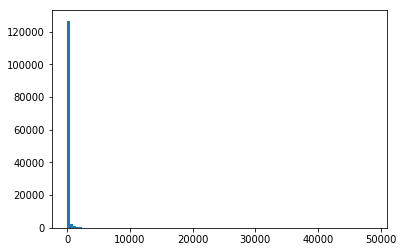

In [12]:
plt.hist(scores, bins=100);

Looks like there's quite a dropoff of scores, almost none above 1000. Score normalization or something might be useful -- a large amount of the score is probably due to posting time, so it might be valuable to batch all the score into "unpopular", "semi-popular", and "very popular" or something.

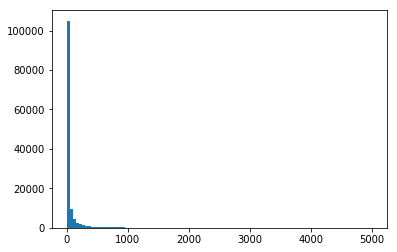

In [13]:
low_scores = [score for score in scores if score<5000]
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the y axis:

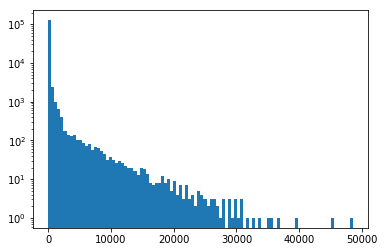

In [14]:
low_scores = [score for score in scores]
plt.yscale('log', nonposy='clip')
plt.hist(low_scores, bins=100);

Here are the Reddit joke score incidences plotted on a log scale on the x axis:

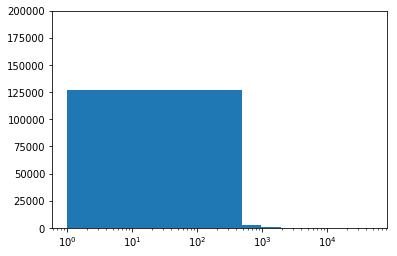

In [15]:
low_scores = [score for score in scores]
plt.xscale('log', nonposx='clip')
plt.ylim(ymax=200000)
#plt.axes.set_ylim([0,200000])
plt.hist(low_scores, bins=100);

In [16]:
title_body = [joke['title']+' '+joke['body'] for joke in rated_jokes]
title_body[0]

'I hate how you cant even say black paint anymore Now I have to say "Leroy can you please paint the fence?"'

Horrible, but formatted correctly. Now, let's combine all the jokes into one long string, using the `EOJ` tag.

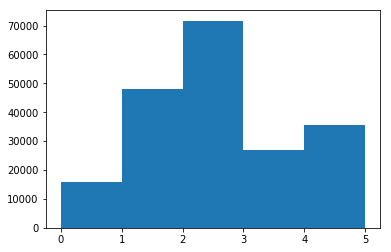

In [17]:
all_jokes = []
for i in range(len(reddit_jokes)):
    r_joke = reddit_jokes[i]
    #|print(r_joke)
    r_joke['rating']=round(math.log(r_joke['score']+random.randrange(1,10))/math.log(10)*5/2, 2)
    if r_joke['rating']>5:
        r_joke['rating']=5
    del r_joke['score'] 
    r_joke['body'] = r_joke['title']+" "+r_joke['body']
    del r_joke['title']
for s_joke in stupid_jokes:
    del s_joke['category']

combined = [joke['rating'] for joke in reddit_jokes]
combined = combined + [joke['rating'] for joke in stupid_jokes]
plt.hist(combined,bins=5);

combined_jokes = reddit_jokes + stupid_jokes

title_body = [joke['body']+' ' for joke in combined_jokes]

In [18]:
text = ''
for joke in title_body:
    text = text + ' ' + joke + ' ' + EOJ + ' '
    if len(text) > 800000: 
        break

In [19]:
len(text)
print(text[1000:1100])

ls ‘Jesus Christ, are you still in there?'”  xeoj  You hear about the University book store worker w


In [20]:
chars = sorted(list(set(text)))
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 125


In [21]:
chars.insert(0, "\0")
print(chars)

['\x00', '\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x9d', '\xa0', '¢', '£', '°', '´', 'è', 'é', 'ñ', 'ó', 'μ', 'π', '–', '—', '‘', '’', '“', '”', '•', '…', '\u2028', '€', '√', '∫', '\ufeff', '🇩', '🇰', '😂', '😨', '🤣']


It appears there are Emojis in the dataset. 

In [22]:
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

In [23]:
idx = [char_indices[c] for c in text]

idx[:10]

[3, 44, 3, 75, 68, 87, 72, 3, 75, 82]

In [24]:
''.join(indices_char[i] for i in idx[:70])

' I hate how you cant even say black paint anymore Now I have to say "L'

Partitioning the dataset and writing it to /data/trn/trn.txt and /data/val/val.txt

In [25]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

models/  reddit_jokes.json  stupidstuff.json  trn/  trngit/  val/


In [26]:
trn = open(TRN+"trn.txt","w")
trn.write("test")
trn.write(str(idx[0:int(len(idx)*2/3)]))
trn.close()
val = open(VAL+"val.txt","w")
val.write("test")
val.write(str(idx[int(len(idx)*2/3):len(idx)-1]))
val.close()

# Emojis in Jokes

How many of them have them?

In [27]:
emojis = chars[-3:]

def containsEmoji(joke):
    for emoji in emojis:
        if emoji in joke:
            return True
    return False

#type(title_body[0])
contains_emoji = [joke for joke in title_body if containsEmoji(joke)]
print(len(contains_emoji))
# contains_emoji

49


So not that many. 
Interestingly though, there seems to be more emojis than we found initially. 
